In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from influxdb_client import InfluxDBClient

INFLUX_URL = os.getenv("INFLUX_URL", "http://localhost:8086")
INFLUX_TOKEN = os.getenv("INFLUX_TOKEN", "bigdata-dev-token")
INFLUX_ORG = os.getenv("INFLUX_ORG", "bigdata")
INFLUX_BUCKET = os.getenv("INFLUX_BUCKET", "bigdata_bucket")

START = os.getenv("STANCE_START", "-30d")
LIMIT = int(os.getenv("STANCE_LIMIT", "5000"))

In [10]:
def fetch_stance_conf(start: str = "-30d", limit: int = 5000) -> pd.DataFrame:
    """Fetch stance_conf + stance_label values from InfluxDB."""
    flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: {start})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> filter(fn: (r) => r._field == "stance_conf" or r._field == "stance_label")
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "stance_conf", "stance_label"])
  |> sort(columns: ["_time"], desc: false)
  |> limit(n: {int(limit)})
"""

    with InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG) as client:
        tables = client.query_api().query(flux, org=INFLUX_ORG)

    rows = []
    for table in tables:
        for record in table.records:
            rows.append(record.values)

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Clean types
    df["stance_conf"] = pd.to_numeric(df.get("stance_conf"), errors="coerce")
    df["stance_label"] = df.get("stance_label", "").fillna("").astype(str)

    return df.dropna(subset=["stance_conf"])


In [11]:
df = fetch_stance_conf(start=START, limit=LIMIT)

print("df created. rows:", len(df), "cols:", list(df.columns))
df.head()

df created. rows: 125 cols: ['result', 'table', '_time', 'stance_conf', 'stance_label']


,result,table,_time,stance_conf,stance_label
0,_result,0,2025-12-17 01:18:24+00:00,0.45,NEUTRAL
1,_result,0,2025-12-18 06:24:32+00:00,0.45,NEUTRAL
2,_result,0,2025-12-18 07:42:14+00:00,0.45,NEUTRAL
3,_result,0,2025-12-19 23:08:30+00:00,0.45,NEUTRAL
4,_result,0,2025-12-22 00:56:22+00:00,0.45,NEUTRAL


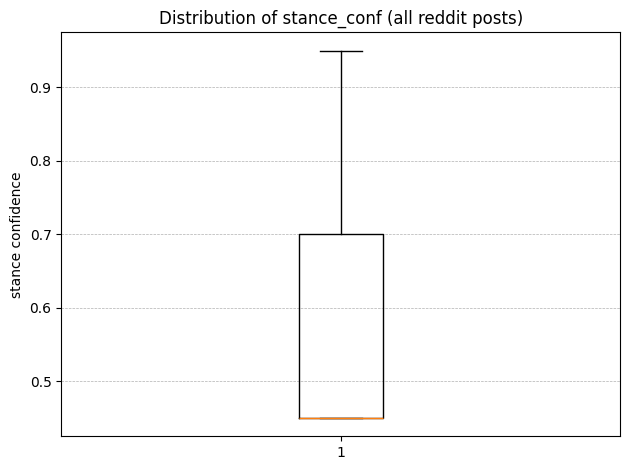

In [12]:
# Single boxplot (no split by stance_label)
plt.figure()
plt.boxplot(df["stance_conf"].values)
plt.ylabel("stance confidence")
plt.title("Distribution of stance_conf (all reddit posts)")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Most of the posts are neutral  (0.45) -> reason for that could be that most of the posts are messy and need to be removed

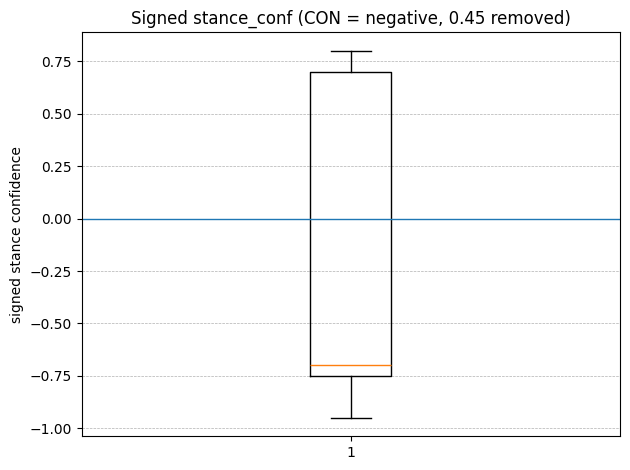

In [13]:


# make sure types are clean
df["stance_conf"] = pd.to_numeric(df["stance_conf"], errors="coerce")
df["stance_label"] = df["stance_label"].fillna("").astype(str)

# drop NaNs
df = df.dropna(subset=["stance_conf"])

# remove neutral default confidence
df = df[df["stance_conf"] != 0.45]

# signed confidence: CON -> negative
df["signed_stance_conf"] = df["stance_conf"]
df.loc[df["stance_label"].str.upper() == "CON", "signed_stance_conf"] *= -1

# boxplot
plt.figure()
plt.boxplot(df["signed_stance_conf"].values)
plt.axhline(0, linewidth=1)
plt.ylabel("signed stance confidence")
plt.title("Signed stance_conf (CON = negative, 0.45 removed)")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


After removing neutral defaults, the discourse around these articles on Reddit is mostly opposing, and often strongly so.